In [43]:
# Standard
import sys, os
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir, "../")))
import config
import json
from collections import defaultdict
import pandas as pd 
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Types (optional for type hints)
from typing import List

# Your SubGraph class (assume already defined/imported)
from SubGraph import SubGraph  # Replace with actual path/module if needed


In [44]:
# Load a list of SubGraphs from a JSONL file
def load_subgraphs_from_jsonl(filepath: str) -> List[SubGraph]:
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    return [SubGraph(**json.loads(line)) for line in lines]

subgraphs = load_subgraphs_from_jsonl("../"+config.SUBGRAPHS_JSONL)
print(f"Loaded {len(subgraphs)} subgraphs.")


Loaded 6124 subgraphs.


In [45]:
def plot_fact_count_distribution(subgraphs: List[SubGraph], bins: int = 50):
    """
    Plots a histogram showing how many facts each SubGraph contains,
    excluding subgraphs with 0 facts (but reports how many were skipped).

    Args:
        subgraphs: List of SubGraph objects.
        bins: Number of bins for the histogram.
    """
    fact_counts = [sg.fact_count for sg in subgraphs]
    
    # Filter out subgraphs with 0 facts
    nonzero_counts = [c for c in fact_counts if c > 0]
    zero_count = len(fact_counts) - len(nonzero_counts)

    plt.figure(figsize=(8, 5))
    plt.hist(nonzero_counts, bins=bins, edgecolor='black', color='steelblue')
    
    plt.xlabel("Number of Facts per SubGraph")
    plt.ylabel("Number of SubGraphs")
    plt.title("Distribution of Fact Counts (Excluding 0)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Mention how many 0-fact subgraphs were excluded
    plt.legend([f"{zero_count} subgraphs with 0 facts excluded"])
    
    plt.tight_layout()
    plt.show()


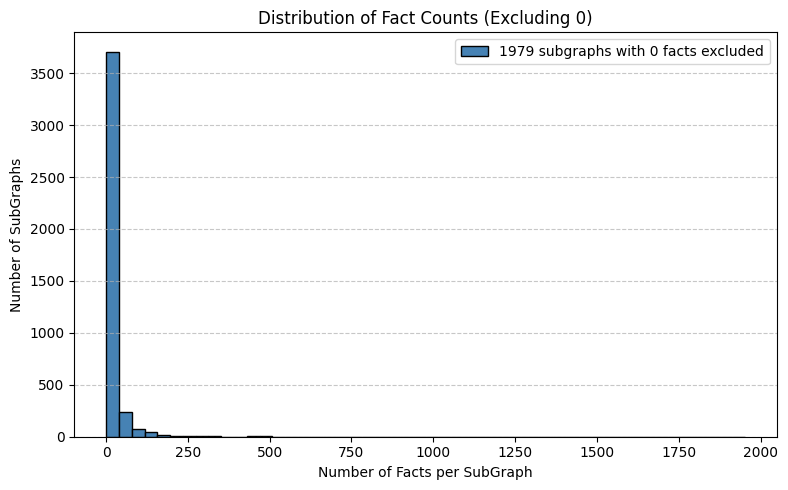

In [46]:
plot_fact_count_distribution(subgraphs)

In [47]:
def plot_valid_subgraphs_per_ticker(subgraphs: List[SubGraph], min_facts: int = 5):
    """
    Plots how many valid SubGraphs each ticker has (valid = fact_count >= min_facts).
    Includes all tickers from the metadata file, even those with 0 valid subgraphs.
    """
    # Step 1: Load all tickers from metadata CSV
    metadata = pd.read_csv("../"+config.METADATA_CSV_FILEPATH)
    all_tickers = metadata['Symbol'].dropna().unique()

    # Step 2: Count valid subgraphs per ticker
    ticker_counts = defaultdict(int)
    for sg in subgraphs:
        if sg.fact_count >= min_facts:
            ticker_counts[sg.primary_ticker] += 1

    # Step 3: Create full count dictionary (fill missing tickers with 0)
    full_counts = {ticker: ticker_counts.get(ticker, 0) for ticker in all_tickers}

    # Step 4: Sort for nicer plotting
    sorted_items = sorted(full_counts.items(), key=lambda x: x[1], reverse=True)
    tickers, counts = zip(*sorted_items) if sorted_items else ([], [])

    # Step 5: Plot
    x = np.arange(len(tickers))
    bar_width = 0.6

    plt.figure(figsize=(max(10, len(tickers) * 0.5), 6))
    plt.bar(x, counts, width=bar_width, color='skyblue', edgecolor='black')
    plt.xticks(ticks=x, labels=tickers, rotation=45, ha='right')

    # Remove excess white space
    if len(x) > 0:
        plt.xlim(x[0] - bar_width / 2, x[-1] + bar_width / 2)

    plt.xlabel("Ticker")
    plt.ylabel(f"Number of SubGraphs with ≥{min_facts} Facts")
    plt.title("Valid SubGraphs per Ticker (Including Zeros)")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    print(sorted_items)  # Print the full counts for debugging


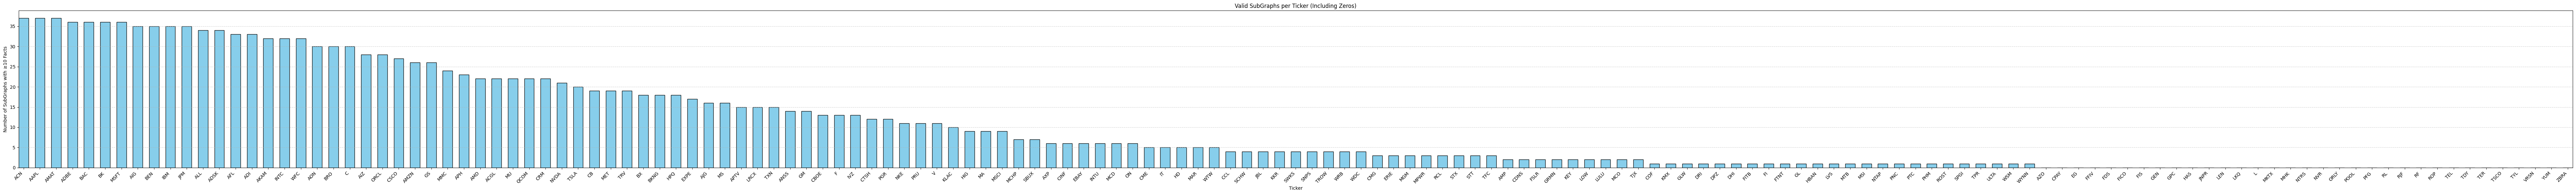

[('ACN', 37), ('AAPL', 37), ('AMAT', 37), ('ADBE', 36), ('BAC', 36), ('BK', 36), ('MSFT', 36), ('AIG', 35), ('BEN', 35), ('IBM', 35), ('JPM', 35), ('ALL', 34), ('ADSK', 34), ('AFL', 33), ('ADI', 33), ('AKAM', 32), ('INTC', 32), ('WFC', 32), ('AON', 30), ('BRO', 30), ('C', 30), ('AIZ', 28), ('ORCL', 28), ('CSCO', 27), ('AMZN', 26), ('GS', 26), ('MMC', 24), ('APH', 23), ('AMD', 22), ('ACGL', 22), ('MU', 22), ('QCOM', 22), ('CRM', 22), ('NVDA', 21), ('TSLA', 20), ('CB', 19), ('MET', 19), ('TRV', 19), ('BX', 18), ('BKNG', 18), ('HPQ', 18), ('EXPE', 17), ('AJG', 16), ('MS', 16), ('APTV', 15), ('LRCX', 15), ('TXN', 15), ('ANSS', 14), ('GM', 14), ('CBOE', 13), ('F', 13), ('IVZ', 13), ('CTSH', 12), ('PGR', 12), ('NKE', 11), ('PRU', 11), ('V', 11), ('KLAC', 10), ('HIG', 9), ('MA', 9), ('MSCI', 9), ('MCHP', 7), ('SBUX', 7), ('AXP', 6), ('CINF', 6), ('EBAY', 6), ('INTU', 6), ('MCD', 6), ('ON', 6), ('CME', 5), ('IT', 5), ('HD', 5), ('MAR', 5), ('WTW', 5), ('CCL', 4), ('SCHW', 4), ('JBL', 4), ('KKR

In [49]:
plot_valid_subgraphs_per_ticker(subgraphs, min_facts=10)